MAE: 36.09 mW
RMSE: 46.62 mW
R² Score: 0.43


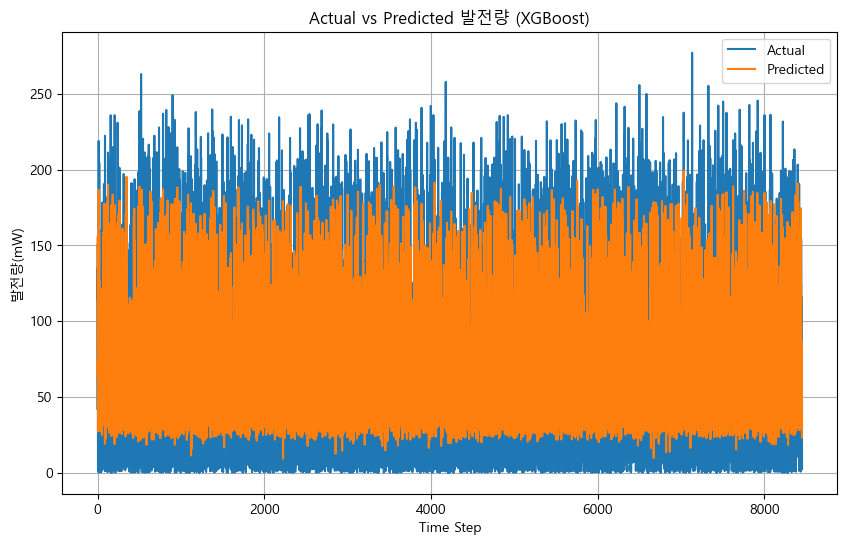

In [6]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 폰트깨짐 방지 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
file_path = "./processed/Jeju_MergedData_20241217.csv"
data = pd.read_csv(file_path, encoding="EUC-KR")

# 공기밀도 계산
R = 287.05  # 공기 상수 (J/kg·K)
data["공기밀도(kg/m^3)"] = data["현지기압(hPa)"] * 100 / (R * (data["기온(°C)"] + 273.15))

# 변수 선택
features = ["기온(°C)", "풍속(m/s)", "현지기압(hPa)", "공기밀도(kg/m^3)"]
target = "발전량(mW)"

X = data[features].values
y = data[target].values

# 데이터 정규화 (0~1 범위로 스케일링)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# 훈련 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 학습
xgb_model = XGBRegressor(
    n_estimators=1000,        # 트리 개수
    learning_rate=0.01,       # 학습률
    max_depth=6,              # 트리의 최대 깊이
    subsample=0.8,            # 데이터 샘플링 비율
    colsample_bytree=0.8,     # 각 트리에서 사용할 feature 비율
    random_state=42
)

# 학습 (조기 종료 설정)
xgb_model.fit(
    X_train, y_train,
    verbose=True                  # 학습 상태 출력
)

# 테스트 데이터 예측
y_pred = xgb_model.predict(X_test)

# 스케일 복원 (역정규화)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# 성능 평가
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"MAE: {mae:.2f} mW")
print(f"RMSE: {rmse:.2f} mW")
print(f"R² Score: {r2:.2f}")
# =============================================================================
# MAE: 36.14 mW
# RMSE: 46.64 mW
# R² Score: 0.43

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(y_pred_rescaled, label="Predicted")
plt.title("Actual vs Predicted 발전량 (XGBoost)")
plt.xlabel("Time Step")
plt.ylabel("발전량(mW)")
plt.legend()
plt.grid()
plt.show()
